# Analyse, classification et indexation des données: feuille 8
### Réduction de dimension - Analyse linéaire discriminante (LDA)

#### Avant de commencer

Dans cet exercice, on s'intéresse à l'application de l'analyse linéaire discriminante (LDA) à un corpus de données. Le but est de réduire la dimension tout en conservant une séparation entre les classes. 

<i>Questions préliminaires : </i> 

1. Quelle est la différence entre une ACP et une LDA ?

2. Quelle est la fonction objective que l'on cherche à minimiser quand on fait une LDA ?

## Exercice 1.

Dans cet exercice, on considère le corpus sur la classification des vins. Ce corpus fait partie de l'ensemble des <code>datasets</code> du module <code>sklearn.datasets</code>. Il peut être chargé en invoquant la méthode <code>load_wine()</code>.


### Préparation des données 

1. Chargez le corpus, explorez-le. 

In [1]:
from sklearn.datasets import load_wine
import pandas as pd

# Charger le corpus sur la classification des vins
wine_data = load_wine()

2. Créez un <code>DataFrame data</code>  contenant les variables indépendantes et mettez les classes dans une variable dépendante $target$. Quelle est la taille du corpus ? Combien de variables comporte-t-il ?

In [2]:
# Créer un DataFrame à partir des données
wine_df = pd.DataFrame(data=wine_data.data, columns=wine_data.feature_names)
wine_df['target'] = wine_data.target



In [3]:
# Afficher les premières lignes du DataFrame
print(wine_df.head())

   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0          

3. En utilisant la fonction <code>concat</code>, constituez un seul corpus <code>dataset</code> contenant et <code>data</code> et <code>target</code>. Faites un mélange des données 

In [10]:
from sklearn.utils import shuffle

# Concaténer data et target
dataset = pd.concat([wine_df.drop('target', axis=1), wine_df['target']], axis=1) 

# Mélanger les données
dataset_shuffled = shuffle(dataset, random_state=42)

In [11]:
# Afficher les premières lignes du nouveau dataset
print(dataset_shuffled.head())

     alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
19     13.64        3.10  2.56               15.2      116.0           2.70   
45     14.21        4.04  2.44               18.9      111.0           2.85   
140    12.93        2.81  2.70               21.0       96.0           1.54   
30     13.73        1.50  2.70               22.5      101.0           3.00   
67     12.37        1.17  1.92               19.6       78.0           2.11   

     flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
19         3.03                  0.17             1.66             5.10  0.96   
45         2.65                  0.30             1.25             5.24  0.87   
140        0.50                  0.53             0.75             4.60  0.77   
30         3.25                  0.29             2.38             5.70  1.19   
67         2.00                  0.27             1.04             4.68  1.12   

     od280/od315_of_diluted_wines  pro

#### LDA "à la main"

Dans un premier temps, nous allons appliquer la méthode d'analyse linéaire discriminante juste sur deux classes. Nous allons donc d'abord ne garder que les vins des classes 1 et 2. Nous allons également ne conserver que deux descripteurs <code>alcohol</code> et <code>color_intensity</code>.

1. Ecrivez les instructions permettant de faire ce filtrage

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Réinitialiser les indices du DataFrame après le mélange
dataset_shuffled = dataset_shuffled.reset_index(drop=True)

# Filtrer les données pour ne conserver que les classes 1 et 2
var = dataset_shuffled['target'].isin([1, 2])
print(dataset_shuffled)
subset_data = dataset_shuffled[var]

# Sélectionner les descripteurs 'alcohol' et 'color_intensity'
X = subset_data[['alcohol', 'color_intensity']].values

     alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0      13.64        3.10  2.56               15.2      116.0           2.70   
1      14.21        4.04  2.44               18.9      111.0           2.85   
2      12.93        2.81  2.70               21.0       96.0           1.54   
3      13.73        1.50  2.70               22.5      101.0           3.00   
4      12.37        1.17  1.92               19.6       78.0           2.11   
..       ...         ...   ...                ...        ...            ...   
173    13.86        1.51  2.67               25.0       86.0           2.95   
174    12.25        1.73  2.12               19.0       80.0           1.65   
175    14.38        1.87  2.38               12.0      102.0           3.30   
176    12.69        1.53  2.26               20.7       80.0           1.38   
177    12.34        2.45  2.46               21.0       98.0           2.56   

     flavanoids  nonflavanoid_phenols  proanthocyan

2. Quelles sont les étapes (théoriques) pour réaliser une LDA ?

ETAPES: 
    1. Séparer les classes: D = D0, D1
    2. Moyenne de D0 et D1 pour chaque descripteurs
    3. Calculer les matrices de disperssion intra classes Sw
    4. Inverser la matrice Sw
    5. S = Sw_inv@SB

3. Application numérique : appliquer les étapes de la questions précédente pour réaliser une LDA. Quel est le vecteur directeur du meilleur axe de projection selon la méthode LDA ?

In [16]:
# Sélectionner les étiquettes de classe
y = subset_data['target'].values

# Calculer les moyennes de chaque descripteur pour chaque classe
µ0 = np.mean(X[y == 1], axis=0)
µ1 = np.mean(X[y == 2], axis=0)
SB = µ0 - µ1
SB = SB[:,None]@SB[None,:]

# Calculer les matrices de dispersion intra-classes (Sw)
S0 = np.cov((X[y==1].shape[0] - 1)*X[y==1], rowvar=False)
S1 = np.cov((X[y==2].shape[0] - 1)*X[y==2], rowvar=False)
Sw = S0 + S1

#inversement de Sw
Sw_inv = np.linalg.inv(Sw)  

#
S = Sw_inv@SB

3. Visualiser le résultat. Donnez les deux graphiques, avant et après la projection.

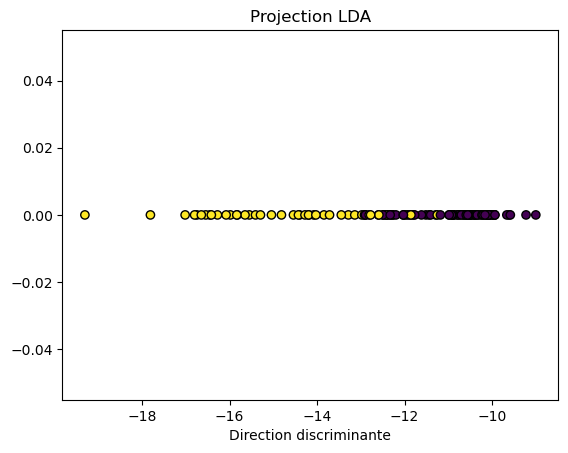

In [23]:
# Calculer la différence entre les moyennes des classes
mean_diff = (µ0 - µ1).reshape((-1, 1))

# Calculer la matrice de dispersion inter-classes (Sb)
sb = np.dot(mean_diff, mean_diff.T)

# Calculer les valeurs propres et vecteurs propres de (Sw^(-1)) * Sb
eigenvalues, eigenvectors = np.linalg.eig(np.dot(np.linalg.inv(Sw), sb))

# Sélectionner le vecteur propre correspondant à la plus grande valeur propre
best_eigenvector = eigenvectors[:, np.argmax(eigenvalues)]

# Projeter les données sur la direction du vecteur propre sélectionné
X_projected = np.dot(X, best_eigenvector)

##### Avant la projection : 

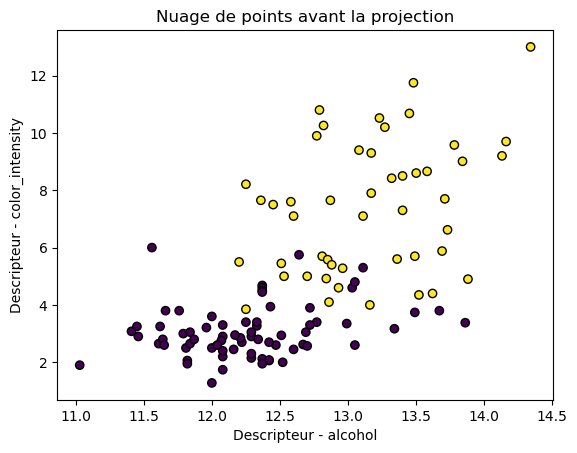

In [24]:
# Créer une instance de LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

# Appliquer la LDA sur les données X
X_lda = lda.fit_transform(X, y)

# Afficher le nuage de points avant la projection
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k', marker='o')
plt.title('Nuage de points avant la projection')
plt.xlabel('Descripteur - alcohol')
plt.ylabel('Descripteur - color_intensity')
plt.show()

#### Après la projection :

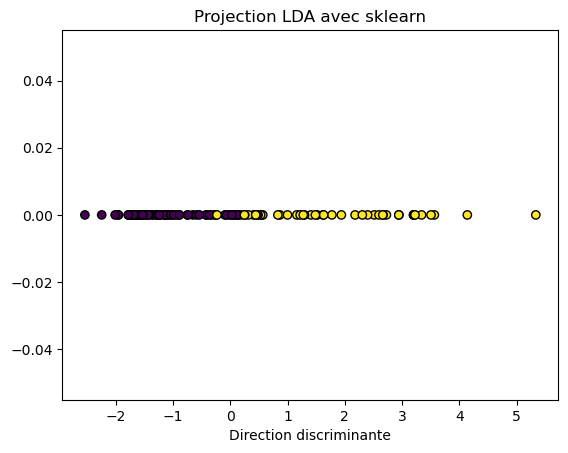

In [25]:
# Afficher le nuage de points après la projection LDA
plt.scatter(X_lda[:, 0], np.zeros_like(X_lda[:, 0]), c=y, cmap='viridis', edgecolors='k', marker='o')
plt.title('Projection LDA avec sklearn')
plt.xlabel('Direction discriminante')
plt.show()

### LDA avec <code>sklearn</code>

Réalisez une LDA en utilisant la bibliothèque <code>sklearn.discriminant_analysis</code>. Comparez le résultat avec  la projection que vous avez obtenu dans la section précédente. 

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

In [20]:
# Créer une instance de LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

In [21]:
# Appliquer la LDA sur les données X
X_lda = lda.fit_transform(X, y)

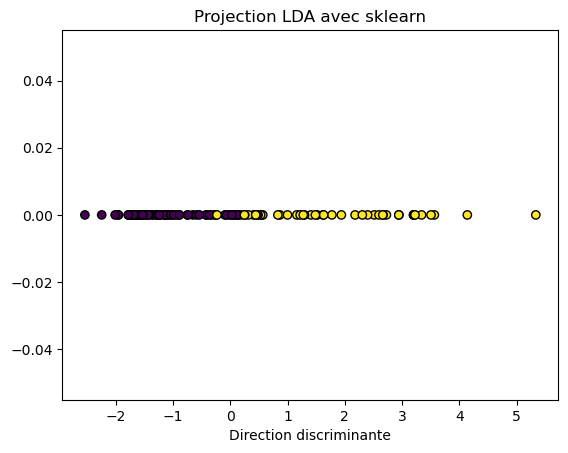

In [22]:
# Afficher le nuage de points projeté par la LDA
plt.scatter(X_lda[:, 0], np.zeros_like(X_lda[:, 0]), c=y, cmap='viridis', edgecolors='k', marker='o')
plt.title('Projection LDA avec sklearn')
plt.xlabel('Direction discriminante')
plt.show()

### LDA sur tout le corpus 

Nous allons à présent appliquer la LDA sur tout le corpus. L'objectif est d'observer l'impact de la projection à la fois sur l'efficacité (<code>accuracy</code>) de la classification et sur le temps d'apprentissage. 

1. Rechargez les données et faites votre LDA.

2. Quel est le ratio de la variance expliqué par les axes obtenus ?

3. Visualiser le résultat. 

### Classification avant/après réduction

1. En utilisant un classifieur bayésien MAP, comparez les résultats obtenus avec les échantillons bruts et les résultats obtenus avec les échantillons projetés sur les axes fournis par la LDA. Comparez également les temps d'entraînement.

2. Même question avec un $k$-nn.

### Exercice 2.

Dans cet exercice, nous allons travailler avec le même corpus que le précédent TD : les données sur le cancer du sein. Le corpus peut être chargé par l'instruction <code> load_breast_cancer</code> de la bibliothèque <code>sklearn.datasets</code>.




Comparer les effets de l'ACP et de la LDA sur la classification de ce corpus.

1. Faites une ACP en utilisant le module <code>PCA</code> de la bibliothèque <code>sklearn.decomposition</code>.  

Attention : pensez à centrer et réduire vos données.

2. Affichez l'éboulie des valeurs propres et indiquer le nombre d'axes à retenir en utilisant le critère du coude. 

3. Voyons ce qu'est l'impact de l'ACP

4. puis celui de la LDA